In [1]:
## environment
# conda create -n base2023geonat python numpy pandas scipy matplotlib jupyterlab nodejs plotly dill; conda install -c conda-forge pyinaturalist; 
# pip install ipyplot
# conda activate base2023geonat; conda update --all; conda install -c conda-forge 'pyrate-limiter<3' ## for now required pending fix

## imports
import requests
import pandas as pd
import datetime as dt
from typing import Tuple, Union
from time import sleep
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import ipyplot
from io import BytesIO
import pyinaturalist as inat
import dill
import os
import sys

sys.path.insert(0, r"F:\extended_desktop\code")
from pynat import helpers

pd.options.display.max_rows=250

In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
assert False, "run once to set up your iNat access key"

## save API_KEY

API_KEY = ""

with open('pyinaturalistkey.pkd', 'wb') as f:
    dill.dump(API_KEY, f)

In [ ]:
# ## load api key
# with open('pyinaturalistkey.pkd', 'rb') as f:
#     API_KEY = dill.load(f)

In [ ]:
# import logging
# logging.basicConfig()
# logging.getLogger('pyinaturalist').setLevel('INFO')

### learn about identifications by location of identified not location of identifier

In [3]:
PLACES = {1491:'Powhatan County',
          2920:'Goochland County',
          3032:'Louisa County'}
local_ids = inat.v1.identifications.get_identifications(place_id=list(PLACES.keys()))
local_ids['results'][0].keys()

dict_keys(['id', 'uuid', 'user', 'created_at', 'created_at_details', 'body', 'category', 'current', 'flags', 'own_observation', 'taxon_change', 'vision', 'disagreement', 'previous_observation_taxon_id', 'spam', 'taxon_id', 'hidden', 'current_taxon', 'taxon', 'observation', 'moderator_actions'])

### check accuracy of identifications

# tri-county stats

In [4]:
PLACES = {1491:'Powhatan County',
          2920:'Goochland County',
          3032:'Louisa County'}

total_observations = inat.get_observations(
    place_id=list(PLACES.keys()),
    verifiable=True,
    per_page=0,
)['total_results']
print(f'Total observations: {total_observations}')

total_taxa = inat.get_observation_species_counts(
    place_id=list(PLACES.keys()),
    verifiable=True,
    per_page=0,
)['total_results']
print(f'Total taxa observed: {total_taxa}')

total_identifiers = inat.get_observation_identifiers(place_id=list(PLACES.keys()), per_page=0)['total_results']
print(f'Total identifiers: {total_identifiers}')

total_observers = inat.get_observation_observers(place_id=list(PLACES.keys()), per_page=0)['total_results']
print(f'Total observers: {total_observers}')

Total observations: 59338
Total taxa observed: 5223
Total identifiers: 4018
Total observers: 2585


In [5]:
## helper functions from pyinaturalist example

THROTTLING_DELAY = 1.0  # Time to wait in between subsequent requests
TAXON_IMAGE_URL = 'https://raw.githubusercontent.com/inaturalist/inaturalist/main/app/assets/images/iconic_taxa/{taxon}-75px.png'
iconic_taxa = list(inat.ICONIC_TAXA.values())
iconic_taxa.remove('Unknown')

# Run one search for each iconic taxon
def get_iconic_taxa_counts(function):
    iconic_taxa_counts = {}
    for taxon_name in iconic_taxa:
        total_taxon_observations = function(
            place_id=list(PLACES.keys()),
            iconic_taxa=taxon_name,
            verifiable=True,
            per_page=0,
        )['total_results']

        iconic_taxa_counts[taxon_name] = total_taxon_observations
        print(f'Total results for {taxon_name}: {total_taxon_observations}')
        if taxon_name != iconic_taxa[-1]:
            sleep(THROTTLING_DELAY)
    return iconic_taxa_counts

def get_iconic_icon(taxon_name):
    return TAXON_IMAGE_URL.format(taxon=taxon_name.lower())

In [6]:
total_observations_by_iconic_taxon = get_iconic_taxa_counts(inat.get_observations)

# Create a chart, sorted by number of observations, using the appropriate iNaturalist icons
observations_df = pd.DataFrame(
    [
        {'iconic taxon': k, 'observations': v, 'img': get_iconic_icon(k)}
        for k, v in total_observations_by_iconic_taxon.items()
    ]
)

# ## display with altair
# alt.Chart(
#     observations_df,
#     title=f'Verifiable observations in {PLACE_NAME} by iconic taxon',
#     width=750,
#     height=500,
# ).mark_image().encode(x=alt.X('iconic taxon:N', sort='-y'), y='observations:Q', url='img')

observations_df.sort_values('observations', ascending=False)

Total results for Animalia: 955
Total results for Aves: 3253
Total results for Amphibia: 1699
Total results for Reptilia: 1360
Total results for Mammalia: 893
Total results for Actinopterygii: 276
Total results for Mollusca: 296
Total results for Arachnida: 2356
Total results for Insecta: 20603
Total results for Plantae: 22235
Total results for Fungi: 4798
Total results for Chromista: 167
Total results for Protozoa: 153


iconic taxon  observations  \
9          Plantae         22235   
8          Insecta         20603   
10           Fungi          4798   
1             Aves          3253   
7        Arachnida          2356   
2         Amphibia          1699   
3         Reptilia          1360   
0         Animalia           955   
4         Mammalia           893   
6         Mollusca           296   
5   Actinopterygii           276   
11       Chromista           167   
12        Protozoa           153   

                                                  img  
9   https://raw.githubusercontent.com/inaturalist/...  
8   https://raw.githubusercontent.com/inaturalist/...  
10  https://raw.githubusercontent.com/inaturalist/...  
1   https://raw.githubusercontent.com/inaturalist/...  
7   https://raw.githubusercontent.com/inaturalist/...  
2   https://raw.githubusercontent.com/inaturalist/...  
3   https://raw.githubusercontent.com/inaturalist/...  
0   https://raw.githubusercontent.com/inaturalist/...  
4   https://raw.githubusercontent.com/inaturalist/...  
6   https://raw.githubusercontent.com/inaturalist/...  
5   https://raw.githubusercontent.com/inaturalist/...  
11  https://raw.githubusercontent.com/inaturalist/...  
12  https://raw.githubusercontent.com/inaturalist/...

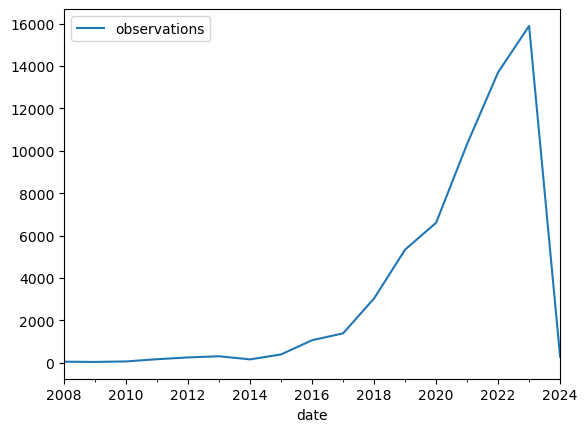

In [7]:
observations_by_year = inat.get_observation_histogram(
    place_id=list(PLACES.keys()),
    interval='year',
    d1='2008-01-01',
    d2=dt.date.today(),
    verifiable=True,
)
observations_by_year = pd.DataFrame(
    [{'date': k, 'observations': v} for k, v in observations_by_year.items()]
)
observations_by_year.set_index('date').plot();

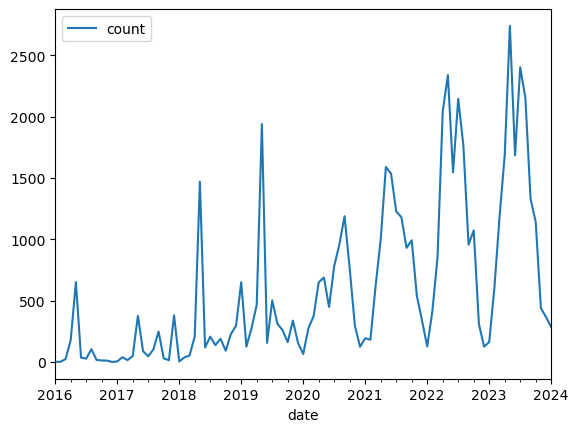

In [8]:
observations_by_month = inat.get_observation_histogram(
    place_id=list(PLACES.keys()),
    interval='month',
    d1='2016-01-02',
    d2=dt.date.today(),
    verifiable=True,
)
observations_by_month = pd.DataFrame(
    [{'metric': 'Observations', 'date': k, 'count': v} for k, v in observations_by_month.items()]
)
observations_by_month.set_index('date').plot();

<Axes: xlabel='date'>

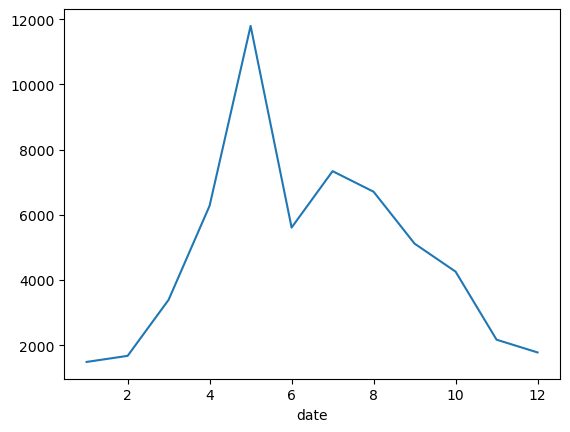

In [9]:
monthly_observations = observations_by_month.groupby(observations_by_month['date'].dt.month)['count'].sum().to_frame()
monthly_observations['metric'] = 'Observations'
monthly_observations['count'].plot()

In [10]:
## helper functions from pyinaturalist example
def count_date_range_results(function, start_date, end_date):
    """Get the count of results for the given date range and search function"""
    # Running this search with per_page=0 will (quickly) return only a count of results, not complete results
    response = function(
        place_id=list(PLACES.keys()),
        d1=start_date,
        d2=end_date,
        verifiable=True,
        per_page=0,
    )
    print(f'Total results for {start_date.strftime("%b")}: {response["total_results"]}')
    return response['total_results']


def get_monthly_counts(function, label):
    """Get the count of results per month for the given search function"""
    month_ranges = inat.get_interval_ranges(dt.datetime(2016, 1, 1), dt.datetime.today(), 'month')
    counts_by_month = {
        start_date: count_date_range_results(function, start_date, end_date)
        for (start_date, end_date) in month_ranges
    }
    return pd.DataFrame(
        [{'metric': label, 'date': k, 'count': v} for k, v in counts_by_month.items()]
    )

### this part didn't quite work...

In [ ]:
taxa_by_month = get_monthly_counts(inat.get_observation_species_counts, 'Taxa')
observers_by_month = get_monthly_counts(inat.get_observation_observers, 'Observers')
identifiers_by_month = get_monthly_counts(inat.get_observation_identifiers, 'Identifiers')

In [ ]:
# taxa_by_month
combined_results = pd.concat([taxa_by_month, observations_by_month, observers_by_month, identifiers_by_month]).pivot(index='date', columns='metric', values='count')
combined_results.plot()

### back on track after simplifying the scope...

<Axes: >

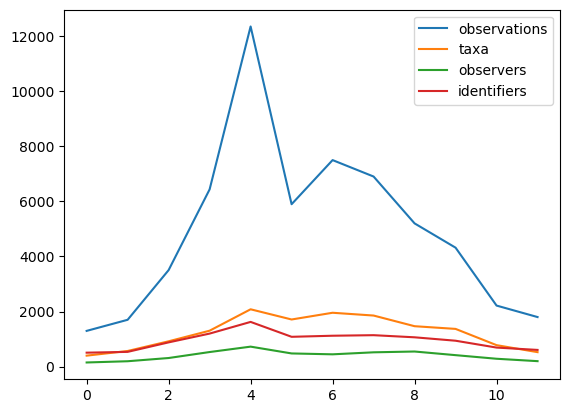

In [22]:
observations = []     
taxa = []
observers = []
identifiers = []

for month in range(1,13):
    observations.append(inat.get_observations(place_id=list(PLACES.keys()), month=month, verifiable=True, per_page=0)['total_results'])
    taxa.append(inat.get_observation_species_counts(place_id=list(PLACES.keys()), month=month, verifiable=True, per_page=0)['total_results'])
    observers.append(inat.get_observation_observers(place_id=list(PLACES.keys()), month=month, verifiable=True, per_page=0)['total_results'])
    identifiers.append(inat.get_observation_identifiers(place_id=list(PLACES.keys()), month=month, verifiable=True, per_page=0)['total_results'])
    
counts = pd.DataFrame({'observations':observations, 'taxa':taxa, 'observers':observers, 'identifiers':identifiers})
counts.plot()

### maybe want to separately count observers vs species IDs? two ways of removing bias.

In [ ]:
## Question: What if I wanted to contrast observation rate versus identification rate? I'd want to index that on the time of identification not the time of observation. 

# convenience: my recent observations, formatted for photo names

In [4]:
# helpers.get_mine(uname='schizoform', lookback_to=dt.datetime(2024,1,29))
helpers.get_mine(uname='schizoform', lookback_to=dt.datetime(2024,2,10))



20240212 Phigalia denticulata (Phigalia denticulata) [inat obs id: 199105007]


<IPython.core.display.HTML object>

<IPython.core.display.HTML object>



20240211 Deroceras laeve (Deroceras laeve) [inat obs id: 199105005]


<IPython.core.display.HTML object>

<IPython.core.display.HTML object>



20240211 Phigalia denticulata (Toothed Phigalia Moth) [inat obs id: 199037560]


<IPython.core.display.HTML object>

<IPython.core.display.HTML object>



20240210 Heleomyzinae (Heleomyzinae) [inat obs id: 198943816]


<IPython.core.display.HTML object>

<IPython.core.display.HTML object>



20240210 Trametes betulina (Gilled Polypore) [inat obs id: 198943815]


<IPython.core.display.HTML object>

<IPython.core.display.HTML object>



20240210 Cladonia cristatella (Cladonia cristatella) [inat obs id: 198943814]


<IPython.core.display.HTML object>

<IPython.core.display.HTML object>



20240210 Brassica (Brassica) [inat obs id: 198943813]


<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

# bloomers
The goal here is to see what plants will be blooming when in my local region. But along the way...

### Coming soon!

what plants might be blooming nest? seeding next? what mushrooms might I see? what (esp. migratory) birds? when are mammals active? 

* DONE alternate entrypoint of specifying lat/long/dist instead of places
* try to narrow time frame to consistently 21-day period?
* normalizations for sort order:
   1. count of all observations at time/place
   2. count of all observations in time and at place separately
   3. count of all observations at time/place by taxa
   4. count of all observations in time and at place separately by taxa
   5. (similar but by phenology?)
   6. (separate totals for 'research grade' and 'informal' counts)
* photographs should match requested phenotype where possible
* add support for caterpillars/butterflies (and similar for benthic macroinverts?)
* split animals by clade and/or generalize interface?

In [18]:
PLACES = {1491:'Powhatan County',
          2920:'Goochland County',
          3032:'Louisa County'}

total_observations = inat.get_observations(
    place_id=list(PLACES.keys()),
    month=list(set( [(dt.date.today()+dt.timedelta(days=-7)).month, (dt.date.today()+dt.timedelta(days=7)).month] )),
    taxon_name='plants',
    verifiable=True,
    per_page=0,
)['total_results']
print(f'Total plant observations: {total_observations}')

inat.get_observations(
    place_id=list(PLACES.keys()),
    month=list(set( [(dt.date.today()+dt.timedelta(days=-7)).month, (dt.date.today()+dt.timedelta(days=7)).month] )),
    taxon_name='plants',
    verifiable=True,
    per_page=0,
)

Total plant observations: 24


{'total_results': 24, 'page': 1, 'per_page': 0, 'results': []}


Hepatica americana (round-lobed hepatica)


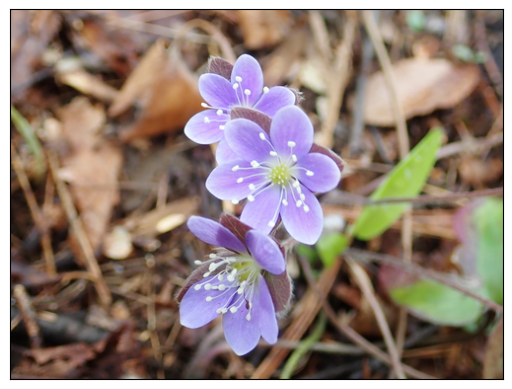


Sanguinaria canadensis (bloodroot)


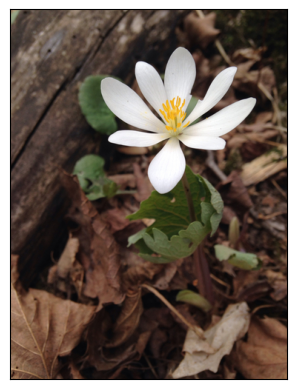


Veronica persica (bird's-eye speedwell)


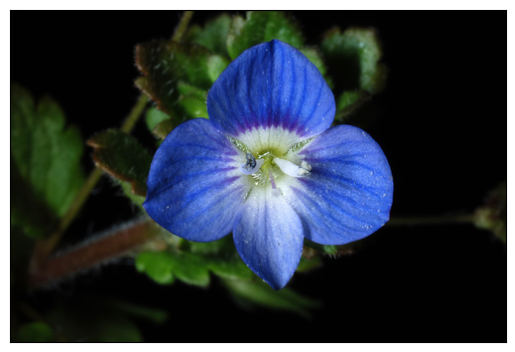

In [23]:
# helpers.coming_soon('flowers', places=list(PLACES.keys()))
res = helpers.coming_soon('flowers', loc=(37.66761, -77.81027, 25), norm='time', limit=3)


Rosa palustris (swamp rose)


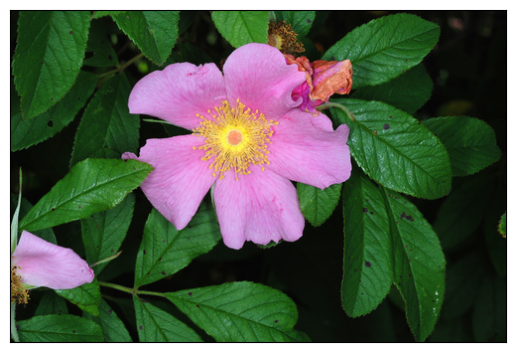


Rosa multiflora (multiflora rose)


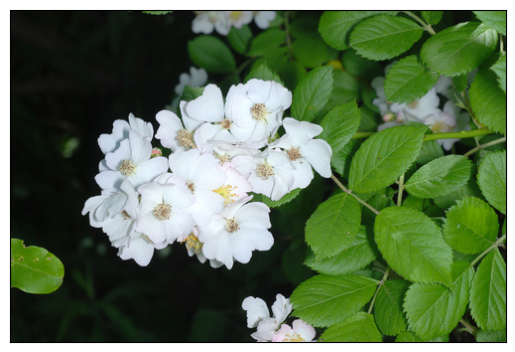


Solanum carolinense (Carolina horsenettle)


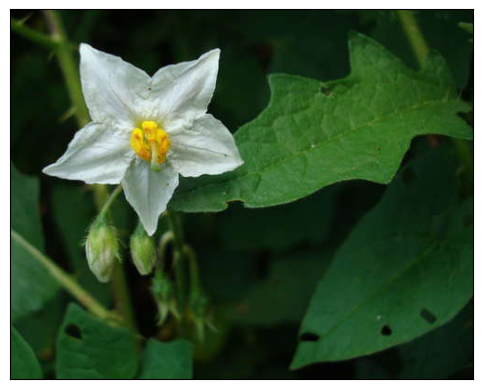

In [24]:
res = helpers.coming_soon('fruits', loc=(37.66761, -77.81027, 25), norm='time', limit=3)


Parmotrema perforatum (perforated ruffle lichen)


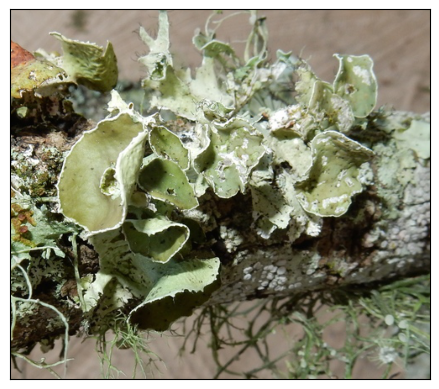


Physcia (rosette lichens)


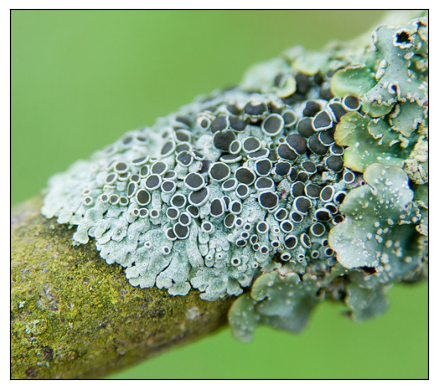


Multiclavula mucida (White green-algae coral)


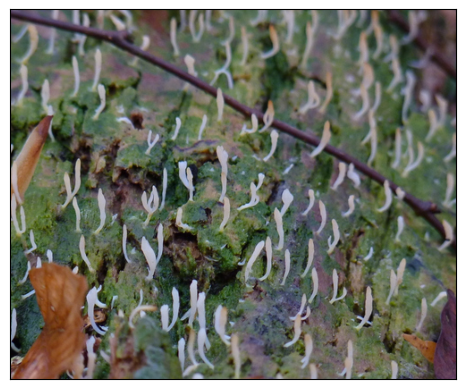

In [25]:
res = helpers.coming_soon('mushrooms', loc=(37.66761, -77.81027, 25), norm='time', limit=3)


Troglodytes hiemalis (Winter Wren)


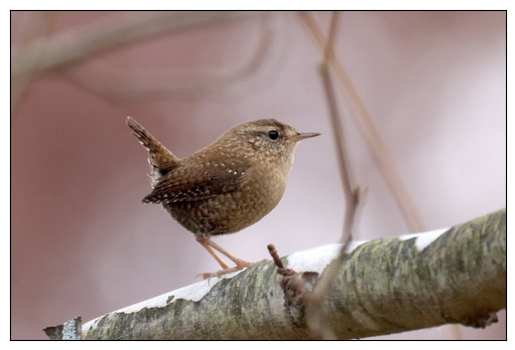


Melospiza georgiana (Swamp Sparrow)


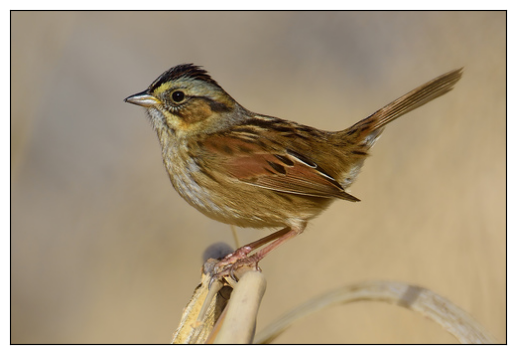

In [26]:
res = helpers.coming_soon('birds', loc=(37.66761, -77.81027, 25), norm='overall', limit=2)


Pseudacris feriarum (Upland Chorus Frog)


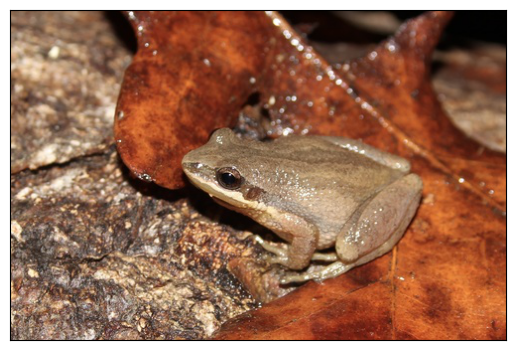


Ambystoma opacum (Marbled Salamander)


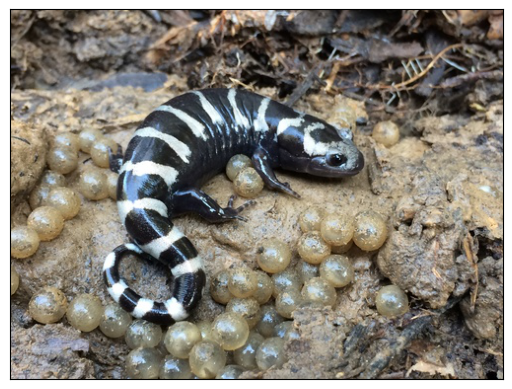

In [27]:
res = helpers.coming_soon('herps', loc=(37.66761, -77.81027, 25), norm='overall', limit=2)


Scalopus aquaticus (Eastern Mole)


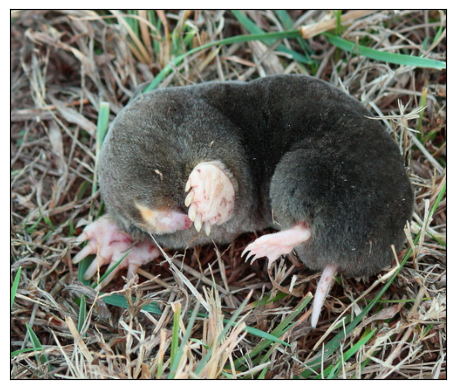


Peromyscus leucopus (White-footed Mouse)


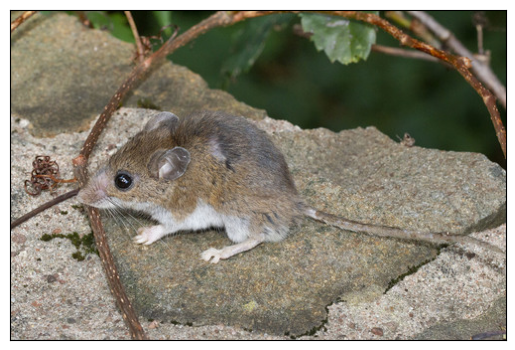

In [28]:
res = helpers.coming_soon('mammals', loc=(37.66761, -77.81027, 25), norm='overall', limit=2)


Chimoptesis gerulae (Carrier Moth)


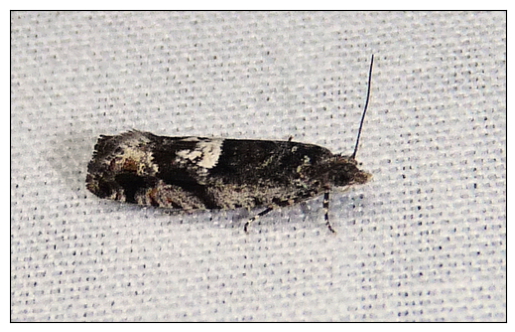


Rhyacionia rigidana (Pitch Pine Tip Moth)


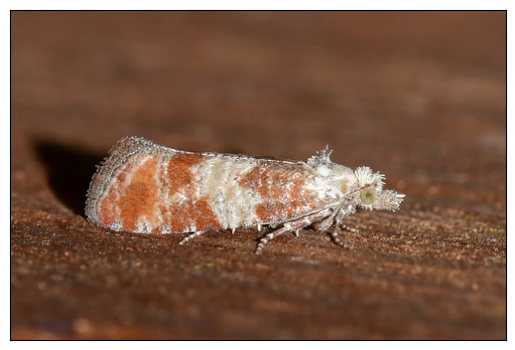

In [29]:
res = helpers.coming_soon('wugs', loc=(37.66761, -77.81027, 25), norm='overall', limit=2)


Hypagyrtis esther (Esther Moth)


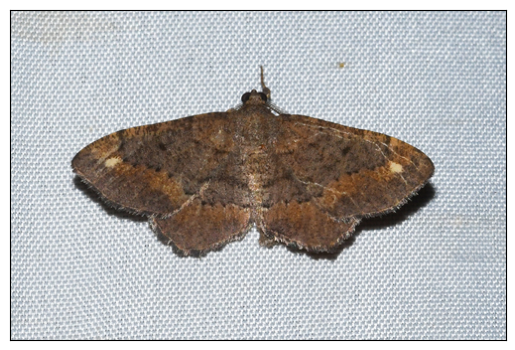


Pyrrharctia isabella (Isabella Tiger Moth)


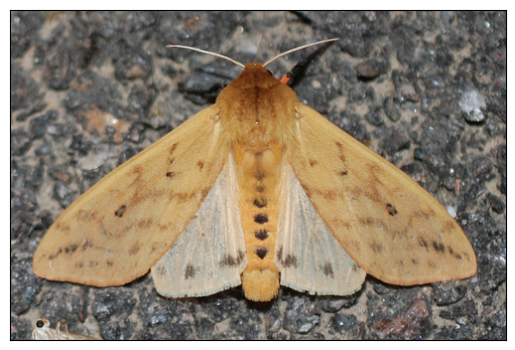

In [30]:
res = helpers.coming_soon('caterpillars', loc=(37.66761, -77.81027, 25), norm='overall', limit=2)


Lithophane patefacta (Dimorphic Pinion)


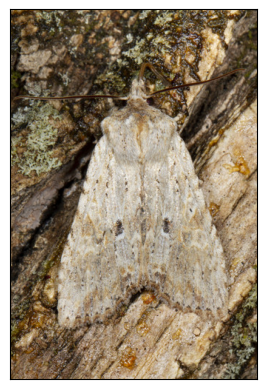


Cerastis tenebrifera (Reddish Speckled Dart)


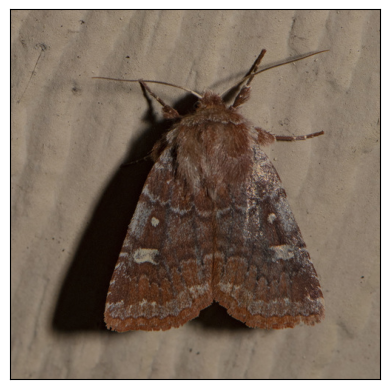

In [31]:
res = helpers.coming_soon('butterflies', loc=(37.66761, -77.81027, 25), norm='overall', limit=2)

# OLD

## confidence_manimal

general idea is to look at the rate at which I ID vs withdraw ID, slash the rate at which I nevermind-withdrawn ID vs the community taxon. how full of shit am I?

In [ ]:
## get a list of all the clades I provided an ID
## idea: give it a user name and an ID -- what percent were subsequently confirmed accurate? confirmed inaccurate?

In [ ]:
## step one: get all a usr's observations (e.g. mine)


def get_species_preview(api_key: str,
                        user: Tuple[float, float], 
                       ) -> pd.DataFrame:
    """
    Fetches observations of flowering plants from the iNaturalist API within a specified distance 
    of a given location over the next two weeks for the past 10 years.

    Args:
        location (Tuple[float, float]): The latitude and longitude of the location of interest.
        distance (Union[int, float]): The radius around the location of interest, in kilometers.
        api_key (str): The iNaturalist API key.

    Returns:
        pd.DataFrame: A DataFrame containing the observations of flowering plants.

    Note:
        The taxon_id parameter is set to 47126, which is the ID for the kingdom Plantae. This will 
        return observations of all plants. If you're interested in a specific group of plants, 
        you'll need to find the appropriate taxon ID.

        The term_id parameter is set to 12, which is the ID for "flowering". This will return 
        observations where the plant was reported to be flowering.
    """
    # Define the base URL for the iNaturalist API
    base_url = "https://api.inaturalist.org/v1/observations"

    # Fetch observations
    
    # Define the parameters for the API request
    params: Dict[str, Union[str, int, float]] = {
        
        "order": "desc",
        "order_by": "observed_on",
        #"term_id": 13,  # Term ID for flowering
    }

    # Make the API request
    response = requests.get(base_url, params=params, headers={"Authorization": "Bearer " + api_key})

    # Convert the response to a pandas DataFrame and append it to the results DataFrame
    df.append(pd.json_normalize(response.json()["results"]))

